In [1]:
import kaggle
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import tree
from sklearn import ensemble
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt

In [2]:
def name_to_status(df):
    title_dict = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Dona": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"}
    
    titles = []
    for name in df['Name']:
        title = name.split(',')[-1].split('.')[0]
        titles.append(title[1:])
    df['Name'] = titles
    
    
    # a map of more aggregated title
    # we map each title
    df['Name'] = df.Name.map(title_dict)
    df.rename(columns = {'Name':'Status'}, inplace = True)
    return df

In [3]:
def cabin_to_deck(df):
    decks = []
    for cabin in df['Cabin']:
        if pd.notna(cabin): decks.append(cabin[0])
        else: decks.append('Basic')
    df['Cabin'] = decks
    df.rename(columns = {'Cabin':'Deck'}, inplace = True)
    return df

In [369]:
def add_ticket_type(df):
    ticket_types = []
    for ticket in df['Ticket']:
        if pd.notna(ticket): 
            ticket_split = ticket.split(' ')
            if len(ticket_split) > 1:
                ticket_type = ticket_split[0]
                ticket_type = ticket_type.replace('.','')
                ticket_type = ticket_type.replace('/','')
                ticket_type = ticket_type.upper()
                ticket_types.append(ticket_type)
            else: ticket_types.append('BASIC')
        else: ticket_types.append(ticket)
    df['TicketType'] = ticket_types
    return df

In [420]:
def add_ticket_number(df):
    ticket_numbers = []
    for ticket in df['Ticket']:
        if ticket == 'LINE': ticket_numbers.append(0)
        elif pd.notna(ticket):
            ticket_split = ticket.split(' ')
            ticket_numbers.append(int(ticket_split[-1]))
        else: ticket_numbers.append(ticket)
    df['TicketNumber'] = ticket_numbers
    return df

In [421]:
def add_age_estimated(df):
    age_estimated = []
    for i in range(len(df)):
        if df['Age'].values[i] != df['Age'].values[i]:
            age_estimated.append(0)
        elif df['Age'].values[i] != int(df['Age'].values[i]) and df['Age'].values[i] > 1:
            age_estimated.append(1)
        else: 
            age_estimated.append(0)
    df['AgeEstimated'] = age_estimated
    return df

In [422]:
def add_fam_size(df):
    fam_size  = []
    for i in range(len(df)):
        fam_size.append(df['SibSp'][i]+df['Parch'][i])
    df['FamSize'] = fam_size
    return df

In [423]:
def add_fare_per_person(df):
    fare_per_person = []
    for i in range(len(df)):
        fare_per_person.append(df['Fare'][i]/(df['FamSize'][i]+1))
    df['FarePerPerson'] = fare_per_person
    return df

In [424]:
def add_age_times_class(df):
    age_times_class = []
    for i in range(len(df)):
        age_times_class.append(df['Pclass'][i]*df['Age'][i])
    df['AgeClass'] = age_times_class
    return df

In [425]:
def fill_ages(df, train_index):
    ages = []
    grouped_train = df.iloc[:train_index].groupby(['Sex','Pclass','Status'])
    grouped_median_train = grouped_train.median()
    grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Status', 'Age']]
    for i, row in df.iterrows():
        if row['Age'] != row['Age']: 
            condition = (
                (grouped_median_train['Sex'] == row['Sex']) & 
                (grouped_median_train['Status'] == row['Status']) & 
                (grouped_median_train['Pclass'] == row['Pclass'])
            ) 
            ages.append(grouped_median_train[condition]['Age'].values[0])
        else: ages.append(row['Age'])
    df['Age'] = ages
    return df

In [426]:
def categorify(df, columns):
    rectifier = 1
    for column in columns:
        category_dict = {}
        unique_categories = df[column].unique()
        unknown_index = (unique_categories != unique_categories).nonzero()[0]
        unique_categories = unique_categories.tolist()

        if len(unknown_index): 
            category_indexes = list(range(len(unique_categories)))
            unknown = unique_categories[unknown_index[0]]
            category_indexes[0] = unknown
            unique_categories.pop(unknown_index[0])
            unique_categories.insert(0,unknown)

        else:
            category_indexes = list(range(1,len(unique_categories)+1))

        for i in range(len(unique_categories)):
            category_dict[unique_categories[i]] = category_indexes[i]

        new_column = []
        for i in range(len(df)):
            new_value = category_dict[df[column][i]]
            if new_value == new_value: new_value = int(new_value)
            new_column.append(new_value)

        df[column] = new_column
#         df[column] = new_column.astype('category')
    return df

In [427]:
def fill_missing(df, ignore_columns):
    for column in df.columns:
        if column in ignore_columns: continue
        elif df[column].isna().any():
            median = df[column].describe()['50%']
            nan_indexes = df[column].isna().values
            new_column = np.array(df[column])
            new_column[nan_indexes] = median
#             new_column = new_column.astype('int')
            df[column] = new_column
            df[f'{column}Missing'] = nan_indexes 
    return df

In [428]:
def integerize(df, columns):
    for column in columns:
        df = df.astype({column: 'int'})
    return df

In [429]:
def metric(predictions, targets):
    return 100*(len((predictions == targets).nonzero()[0]) / len(predictions))

In [430]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
    ).sort_values('imp', ascending=False)

In [431]:
path = '/home/francisco/workspace/titanic_kaggle/titanic'

In [432]:
original_train_df = pd.read_csv(f'{path}/train.csv',low_memory=False)
original_test_df = pd.read_csv(f'{path}/test.csv',low_memory=False)

In [433]:
targets = original_train_df.Survived #Extract targets
complete_df = pd.concat([original_train_df, original_test_df], ignore_index=True)
complete_df.drop(['Survived'], inplace=True, axis=1)

In [434]:
# complete_df.describe()
# complete_df.count()

In [435]:
complete_df = name_to_status(complete_df)
# complete_df = add_age_estimated(complete_df)
complete_df['AgeMissing'] = np.zeros(len(complete_df),'int')
complete_df['AgeMissing'][(complete_df['Age'] != complete_df['Age'])] = 1
complete_df = fill_ages(complete_df, 891)
complete_df = cabin_to_deck(complete_df)
complete_df = add_ticket_type(complete_df)
complete_df = add_ticket_number(complete_df)
complete_df = complete_df.drop(['Ticket'], axis=1)
complete_df = add_fam_size(complete_df)
complete_df['Fare'] = complete_df['Fare'].fillna(complete_df['Fare'].median())
complete_df = add_fare_per_person(complete_df)
# complete_df = add_age_times_class(complete_df)
complete_df['Embarked'] = complete_df['Embarked'].fillna('S')

/tmp/ipykernel_19387/4108268414.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df['AgeMissing'][(complete_df['Age'] != complete_df['Age'])] = 1


In [436]:
# complete_df.count()

In [437]:
# complete_df = complete_df.drop(['Fare'], axis=1)

In [438]:
# cont = ['Age', 'FarePerPerson']
# cat = ['Survived', 'Pclass', 'Title', 'Sex', 'SibSp', 'Parch', 'TicketType', 'Deck', 'Embarked', 'AgeEstimated', 'FamSize', 'AgeClassMissing','AgeMissing', 'FarePerPersonMissing','DeckMissing', 'EmbarkedMissing']

In [439]:
complete_df = categorify(complete_df,['Status', 'Sex', 'Deck', 'Embarked', 'TicketType'])
# complete_df = fill_missing(complete_df, ['Survived'])

In [440]:
train_df = complete_df.iloc[:712]
valid_df = complete_df.iloc[712:891].reset_index()
test_df = complete_df.iloc[891:].reset_index()

In [441]:
# train_df = integerize(train_df, cat)
# valid_df = integerize(valid_df, cat)
# test_df = integerize(test_df, cat[1:])

In [442]:
# train_df = train_df.drop(['AgeMissing','Parch', 'TicketType'], axis = 1)
# valid_df = valid_df.drop(['AgeMissing','Parch', 'TicketType'], axis = 1)
# test_df = test_df.drop(['AgeMissing','Parch', 'TicketType'], axis = 1)

In [443]:
parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 10000, 
              'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}

In [444]:
rf = ensemble.RandomForestClassifier(**parameters)
# rf = ensemble.RandomForestClassifier(n_estimators=10000)

In [445]:
rf.fit(train_df.values,targets[:712])
preds_rf = rf.predict(valid_df.values[:,1:])
metric(preds_rf.astype('int'), targets.values[712:891])

84.91620111731844

In [362]:
rf_feat_importance(rf,valid_df.iloc[:,1:])
# rf_feat_importance(rf,train_df.drop(['Survived'], axis=1))

,cols,imp
2,Status,0.267377
3,Sex,0.240136
13,FarePerPerson,0.085456
8,Fare,0.081733
1,Pclass,0.074134
4,Age,0.057891
9,Deck,0.048879
12,FamSize,0.047476
0,PassengerId,0.034352
5,SibSp,0.023071


In [157]:
# valid_df['Sex'].hist()

/home/francisco/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/home/francisco/.local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/francisco/.local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/francisco/.local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/francisco/.local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestC

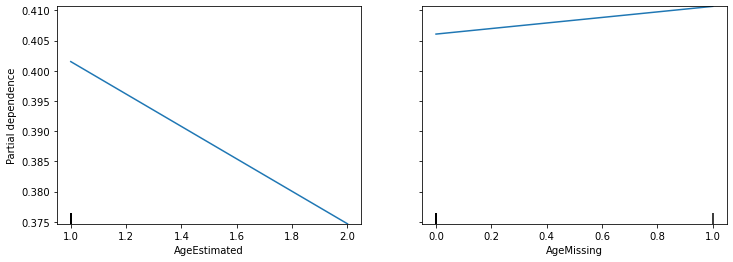

In [156]:
fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(rf, valid_df.iloc[:,1:], ['AgeEstimated','AgeMissing'],
grid_resolution=20, ax=ax);

In [ ]:
85.47

***

In [187]:
# preds_df = pd.DataFrame()
preds_rf_test = rf.predict(test_df.values[:,1:])
preds_rf_df = pd.DataFrame()

# preds_df['PassengerId'] = test_df['PassengerId'].values
# preds_df['Survived'] = preds_clf.astype('int')
preds_rf_df['PassengerId'] = test_df['PassengerId'].values
preds_rf_df['Survived'] = preds_rf_test.astype('int')

In [188]:
preds_rf_df.to_csv(f'{path}/submission_rf.csv',index=False)

***

In [54]:
preds_train = rf.predict(train_df.values[:,2:])

In [55]:
gt = train_df['Survived'].values

In [56]:
np.count_nonzero(preds_train == gt)/len(gt)

0.9876543209876543